In [2]:
import numpy as np
import sympy as sp
from scipy.spatial import ConvexHull

import random
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as Poly
from matplotlib.animation import FuncAnimation
from shapely.geometry import Polygon, LineString, Point
from itertools import combinations

In [3]:
class MyPoly:
    def __init__(self, data):
        self.points = np.array(data)

    def __repr__(self):
        f'Список точек {tuple([tuple(i) for i in self.points])}'

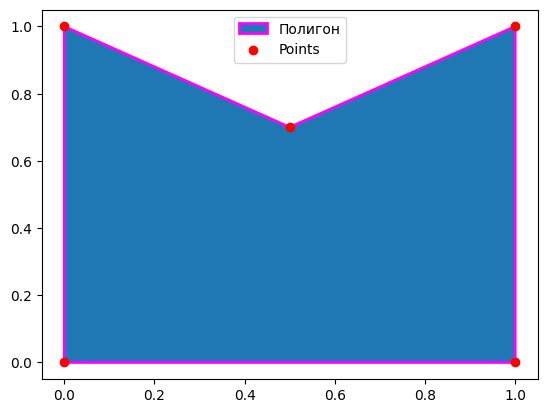

In [4]:
poly = MyPoly([[0, 0],[1, 0], [1, 1], [0.5, 0.7], [0, 1]])
fig, ax = plt.subplots()
ax.add_patch(Poly(poly.points, closed=True, fill=True, edgecolor='magenta', linewidth=2, label='Полигон'))
ax.scatter(poly.points[:, 0], poly.points[:, 1], color='red', label='Points')
ax.legend()
plt.show()

# 1

*ТРИАНГУЛЯЦИЯ ПОЛИГОНА*

In [5]:
def is_point_in_triangle(q, p1, p2, p3):
    """Проверяет, находится ли точка q внутри треугольника p1p2p3."""
    q = np.array(q)
    p1 = np.array(p1)
    p2 = np.array(p2)
    p3 = np.array(p3)
    V = p2-p1
    W = p3-p1
    t, f = sp.Matrix([(q-p1)@V, (q-p1)@W]).T @ sp.Matrix([[V@V, V@W], [V@W, W@W]]).inv()

    # eckb gjl[jlbn ]
    if 0 <= t <= 1 and 0 <= f <= 1 and t + f <= 1:
        return True
    return False

## 1.2

Спроектируйте и реализуйте триангуляцию простого невыпуклого полигона
методом диагоналей.

In [6]:
def triangulate_polygon_diag(vertices):
    """Триангулирует многоугольник, заданный списком вершин."""
    vertices = list(vertices)
    def is_ear(i, vertices):
        p1 = vertices[i - 1]
        p2 = vertices[i]
        p3 = vertices[(i + 1) % len(vertices)]

        polygon = Polygon(vertices)
        triangle = Polygon([p1, p2, p3])
        if not polygon.contains(triangle):
            return False
        
        # Проверяем, является ли треугольник p1p2p3 "ухом" (треугольником который можно вырезать)
        for j in range(len(vertices)):
            if j == i or j == (i - 1) or j == (i + 1) % len(vertices):
                continue
            if is_point_in_triangle(vertices[j], p1, p2, p3):
                return False
        return True

    triangles = []

    while len(vertices) > 3:
        for i in range(len(vertices)):
            if is_ear(i, vertices):
                p1 = vertices[i - 1]
                p2 = vertices[i]
                p3 = vertices[(i + 1) % len(vertices)]
                triangles.append((p1, p2, p3))
                vertices.pop(i)
                break

    # Добавляем последний треугольник
    triangles.append(tuple(vertices))
    return triangles

In [7]:
triangles = triangulate_polygon_diag(poly.points)
triangles

[(array([0., 0.]), array([1., 0.]), array([1., 1.])),
 (array([0., 0.]), array([1., 1.]), array([0.5, 0.7])),
 (array([0., 0.]), array([0.5, 0.7]), array([0., 1.]))]

## 1.2

*Спроектируйте и реализуйте триангуляцию простого невыпуклого полигона
методом хорд*

In [8]:
def triangulate_polygon_chords(vertices):
    """Триангулирует многоугольник, заданный списком вершин, с использованием хорд."""
    def is_point_in_triangle(pt, v1, v2, v3):
        """Проверяет, находится ли точка внутри треугольника."""
        def sign(p1, p2, p3):
            return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

        b1 = sign(pt, v1, v2) < 0.0
        b2 = sign(pt, v2, v3) < 0.0
        b3 = sign(pt, v3, v1) < 0.0

        return b1 == b2 == b3

    def is_chord_valid(v1_idx, v2_idx, vertices):
        if abs(v1_idx - v2_idx) == 1 or abs(v1_idx - v2_idx) == len(vertices) - 1:
            return False  # Это смежные вершины, а не хорда

        v1, v2 = vertices[v1_idx], vertices[v2_idx]
        # Проверяем, что хорда не пересекает стороны многоугольника
        for i in range(len(vertices)):
            v3, v4 = vertices[i], vertices[(i + 1) % len(vertices)]
            if not np.array_equal(v3, v1) and not np.array_equal(v3, v2) and \
               not np.array_equal(v4, v1) and not np.array_equal(v4, v2):
                if segments_intersect(v1, v2, v3, v4):
                    return False
        polygon = Polygon(vertices)
        mid_point = Point((v1[0] + v2[0]) / 2, (v1[1] + v2[1]) / 2)
        if polygon.contains(mid_point):
            return True
        else:
            return False

    def segments_intersect(p1, p2, q1, q2):
        """Проверяет, пересекаются ли отрезки p1p2 и q1q2."""
        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])

        return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

    def split_polygon(vertices, v1_idx, v2_idx):
        if v1_idx > v2_idx:
            v1_idx, v2_idx = v2_idx, v1_idx

        part1 = vertices[v1_idx:v2_idx + 1]
        part2 = np.concatenate((vertices[v2_idx:], vertices[:v1_idx + 1]), axis=0)
        return part1, part2

    def recursive_triangulation(vertices):
        if len(vertices) == 3:
            return [tuple(map(tuple, vertices))]

        for i in range(len(vertices)):
            for j in range((i + 1) % len(vertices),  len(vertices)):
                if is_chord_valid(i, j, vertices):
                    part1, part2 = split_polygon(vertices, i, j)
                    # print(part1, part2, sep='\n %')
                    return (recursive_triangulation(part1) +
                            recursive_triangulation(part2))

    return recursive_triangulation(vertices)

In [9]:
triangles1 = triangulate_polygon_chords(poly.points)
print("Триангуляция:", triangles1)

Триангуляция: [((0.0, 0.0), (1.0, 0.0), (1.0, 1.0)), ((0.5, 0.7), (0.0, 1.0), (0.0, 0.0)), ((0.0, 0.0), (1.0, 1.0), (0.5, 0.7))]


In [10]:
import matplotlib.cm as cm
from matplotlib import patches

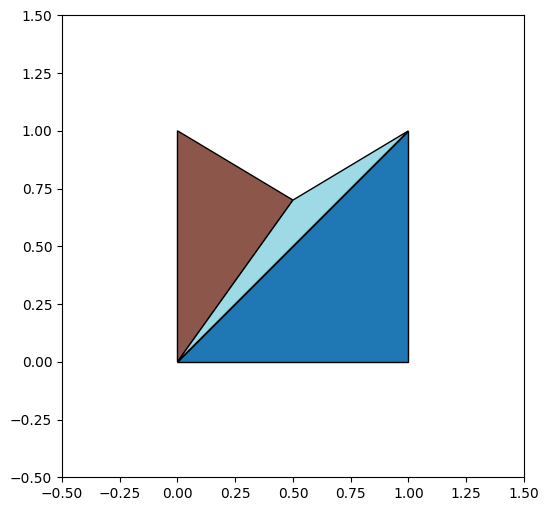

In [11]:
plt.figure(figsize=(6, 6))

num_triangles = len(triangles)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles1, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles for point in triangle]
all_y = [point[1] for triangle in triangles for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)

plt.show()

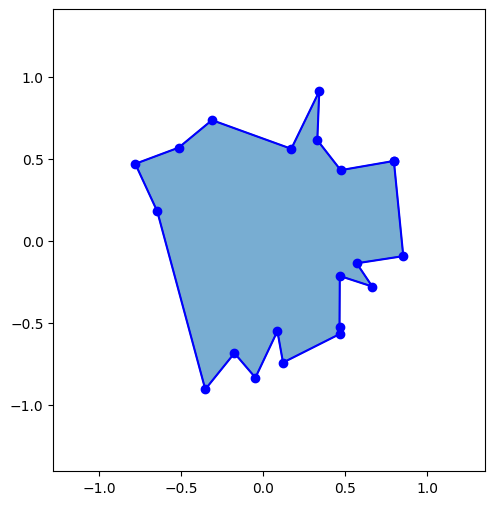

In [14]:
import random

def generate_random_polygon(n_vertices, center=(0, 0), radius=1.0):
    cx, cy = center
    angles = sorted(random.uniform(0, 2 * np.pi) for _ in range(n_vertices))
    vertices = [
        (cx + radius * random.uniform(0.5, 1.0) * np.cos(angle), cy + radius * random.uniform(0.5, 1.0) * np.sin(angle))
        for angle in angles
    ]
    return vertices

random_polygon = generate_random_polygon(20)

plt.figure(figsize=(6, 6))
polygon_patch = patches.Polygon(random_polygon, closed=True, alpha=0.6, edgecolor='black')
plt.gca().add_patch(polygon_patch)

x_coords, y_coords = zip(*random_polygon)
plt.plot(x_coords + (x_coords[0],), y_coords + (y_coords[0],), marker='o', color='blue') 
plt.xlim(min(x_coords) - 0.5, max(x_coords) + 0.5)
plt.ylim(min(y_coords) - 0.5, max(y_coords) + 0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [15]:
random_polygon = np.array(random_polygon)

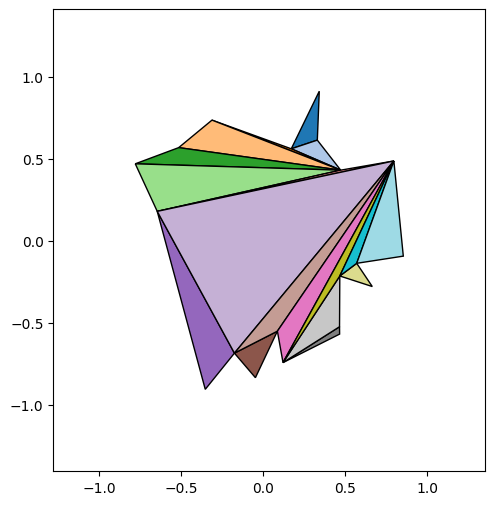

In [16]:
triangles2 = triangulate_polygon_diag(random_polygon)
plt.figure(figsize=(6, 6))

num_triangles = len(triangles2)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles2, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles2 for point in triangle]
all_y = [point[1] for triangle in triangles2 for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)

plt.show()

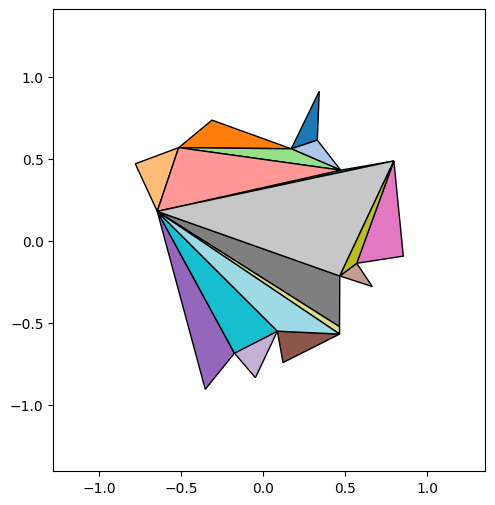

In [17]:
triangles2 = triangulate_polygon_chords(random_polygon)
plt.figure(figsize=(6, 6))

num_triangles = len(triangles2)
colors = cm.tab20(np.linspace(0, 1, num_triangles)) 

for triangle, color in zip(triangles2, colors):
    polygon = patches.Polygon(triangle, closed=True, facecolor=color, alpha=1, edgecolor='black')
    plt.gca().add_patch(polygon)

plt.gca().set_aspect('equal', adjustable='box')

all_x = [point[0] for triangle in triangles2 for point in triangle]
all_y = [point[1] for triangle in triangles2 for point in triangle]
plt.xlim(min(all_x) - 0.5, max(all_x) + 0.5)
plt.ylim(min(all_y) - 0.5, max(all_y) + 0.5)

plt.show()

## 2

In [18]:
def segments_intersect(p1, p2, q1, q2):
    def orientation(a, b, c):
        val = (b[1] - a[1]) * (c[0] - b[0]) - (b[0] - a[0]) * (c[1] - b[1])
        if np.isclose(val, 0):
            return 0
        return 1 if val > 0 else 2

    def on_segment(a, b, c):
        # Проверяет, лежит ли точка b на отрезке a-c
        return (
            min(a[0], c[0]) <= b[0] <= max(a[0], c[0]) and
            min(a[1], c[1]) <= b[1] <= max(a[1], c[1])
        )

    o1 = orientation(p1, p2, q1)
    o2 = orientation(p1, p2, q2)
    o3 = orientation(q1, q2, p1)
    o4 = orientation(q1, q2, p2)

    # Общие случаи пересечения
    if o1 != o2 and o3 != o4:
        return True

    # Проверки на коллинеарность
    if o1 == 0 and on_segment(p1, q1, p2):
        return True
    if o2 == 0 and on_segment(p1, q2, p2):
        return True
    if o3 == 0 and on_segment(q1, p1, q2):
        return True
    if o4 == 0 and on_segment(q1, p2, q2):
        return True

    return False

def greedy_triangulation(points):
    edges = []
    for (i, j) in combinations(range(len(points)), 2):
        # Исключаем смежные точки
        if abs(i - j) == 1 or (i == 0 and j == len(points) - 1):
            continue
        dist = np.linalg.norm(points[i] - points[j])
        edges.append((dist, i, j))
    edges.sort()

    triangulation = []
    polygon = Polygon(points)

    # Добавляем отрезки в триангуляцию, если они не пересекаются (разрешаем пересечение в вершинах)
    for _, i, j in edges:
        new_edge = (points[i], points[j])
        line = LineString(new_edge)
        # Проверяем, находится ли отрезок внутри полигона
        if polygon.contains(line):
            if all(not segments_intersect(new_edge[0], new_edge[1], edge[0], edge[1]) or \
                   np.array_equal(new_edge[0], edge[0]) or np.array_equal(new_edge[0], edge[1]) or \
                   np.array_equal(new_edge[1], edge[0]) or np.array_equal(new_edge[1], edge[1]) \
                   for edge in triangulation):
                triangulation.append(new_edge)

    return triangulation

In [19]:
greedy_triangulation(poly.points)

[(array([0., 0.]), array([0.5, 0.7])), (array([1., 0.]), array([0.5, 0.7]))]

In [20]:
def plot_polygon_and_segments(polygon_points, segments):
    polygon = Polygon(polygon_points)
    line_segments = [LineString([Point(start), Point(end)]) for start, end in segments]
    fig, ax = plt.subplots()
    x, y = polygon.exterior.xy
    ax.fill(x, y, alpha=0.5, color='blue', label='Polygon')
    for line in line_segments:
        x, y = line.xy
        ax.plot(x, y, color='red', linewidth=2, label='Segment')
    ax.set_aspect('equal')
    plt.show()

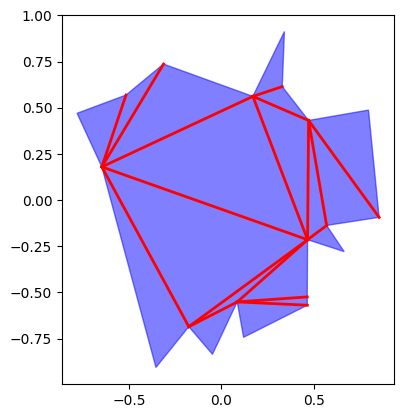

In [21]:
plot_polygon_and_segments(random_polygon, greedy_triangulation(random_polygon))

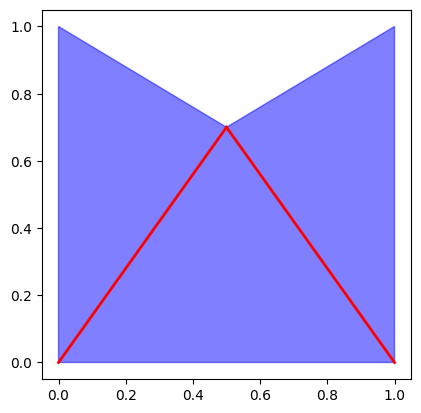

In [22]:
plot_polygon_and_segments(poly.points, greedy_triangulation(poly.points))

### 2.2

In [23]:
import time
import timeit

In [24]:
def measure_time(func, *args):
    start_time = time.time()
    func(*args)
    return time.time() - start_time

In [25]:
greedy_time = measure_time(greedy_triangulation, random_polygon)
chords_time = measure_time(triangulate_polygon_chords, random_polygon)
diag_time = measure_time(triangulate_polygon_diag, random_polygon)

In [26]:
# Для встроенной библиотеки, например, scipy для триангуляции
import scipy.spatial

In [27]:
def scipy_triangulation(points):
    scipy.spatial.Delaunay(points)

In [28]:
scipy_time = measure_time(scipy_triangulation, random_polygon)

In [29]:
print(f"Жадный: {greedy_time:.6f} сек")
print(f"Хордами: {chords_time:.6f} сек")
print(f"Диагоналями: {diag_time:.6f} сек")
print(f"Встройка: {scipy_time:.6f} сек")

Жадный: 0.084563 сек
Хордами: 0.005000 сек
Диагоналями: 0.285878 сек
Встройка: 0.001001 сек
